## Crypto Prediction with LSTM: Ethereum (ETH)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow_addons.metrics import RSquare
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
# from tensorflow.keras.metrics import R2Score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

2023-09-14 11:50:43.490280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-14T00:00:00.0000000Z', 'time_period_end': '2023-09-15T00:00:00.0000000Z', 'time_open': '2023-09-14T00:00:04.4670000Z', 'time_close': '2023-09-14T15:51:54.5910000Z', 'price_open': 1608.1, 'price_high': 1642.9, 'price_low': 1607.5, 'price_close': 1635.2, 'volume_traded': 3742.59786586, 'trades_count': 3593}, {'time_period_start': '2023-09-13T00:00:00.0000000Z', 'time_period_end': '2023-09-14T00:00:00.0000000Z', 'time_open': '2023-09-13T00:00:26.8010000Z', 'time_close': '2023-09-13T23:58:55.8280000Z', 'price_open': 1593.2, 'price_high': 1618.2, 'price_low': 1581.8, 'price_close': 1608.1, 'volume_traded': 4672.30203902, 'trades_count': 4862}, {'time_period_start': '2023-09-12T00:00:00.0000000Z', 'time_period_end': '2023-09-13T00:00:00.0000000Z', 'time_open': '2023-09-12T00:00:07.1670000Z', 'time_close': '2023-09-12T23:59:55.8680000Z', 'price_open': 1551.5, 'price_high': 1622.3, 'price_low': 1549.3, 'price_close': 1593.3, 'volume_traded': 5455.60411831, 'trad

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-14T00:00:00.0000000Z,2023-09-15T00:00:00.0000000Z,2023-09-14T00:00:04.4670000Z,2023-09-14T15:51:54.5910000Z,1608.1,1642.9,1607.5,1635.2,3742.597866,3593
1,2023-09-13T00:00:00.0000000Z,2023-09-14T00:00:00.0000000Z,2023-09-13T00:00:26.8010000Z,2023-09-13T23:58:55.8280000Z,1593.2,1618.2,1581.8,1608.1,4672.302039,4862
2,2023-09-12T00:00:00.0000000Z,2023-09-13T00:00:00.0000000Z,2023-09-12T00:00:07.1670000Z,2023-09-12T23:59:55.8680000Z,1551.5,1622.3,1549.3,1593.3,5455.604118,5349
3,2023-09-11T00:00:00.0000000Z,2023-09-12T00:00:00.0000000Z,2023-09-11T00:00:04.8170000Z,2023-09-11T23:59:44.3110000Z,1616.8,1618.6,1531.1,1551.7,17012.270929,7622
4,2023-09-10T00:00:00.0000000Z,2023-09-11T00:00:00.0000000Z,2023-09-10T00:00:12.4050000Z,2023-09-10T23:59:39.1390000Z,1635.6,1635.6,1596.7,1616.8,3106.311107,4149


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-08-20,298.40
2017-08-21,319.31
2017-08-22,312.22
2017-08-23,315.61
2017-08-24,323.84


In [5]:
# mydata = nasdaqdatalink.get(["WIKI/TSLA.11"])

In [6]:
# print(mydata)

In [7]:
# data = pd.DataFrame(mydata)

# data = data.rename(columns={"WIKI/TSLA - Adj. Close":"Close"})

# data

In [8]:
# data = pd.read_csv('AMZN.csv')
# data = data[["Date", "Adj Close"]]

# #rename columns
# data = data.rename(columns={"Adj Close":"Close"})

# #convert date to dt, refomat to yyyymmdd
# data['Date'] = pd.to_datetime(data['Date']).dt.date


# #set date as index
# data.set_index('Date', inplace=True)

# data.head()



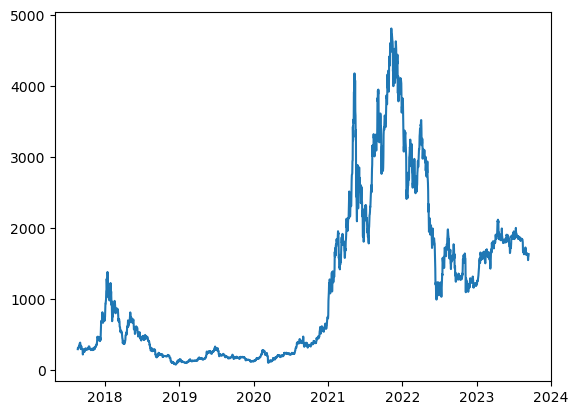

In [9]:
#plot historical amzn price
plt.plot(data)

In [10]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [12]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np)



# check shapes
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((2200, 7), (2200,), (2200,))

In [13]:
# non_positive_indices = np.where(shifted_df_as_np <= 0)
# print(non_positive_indices)


In [14]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1760, 7), (1760,), (220, 7), (220,), (220, 7), (220,))

In [15]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-14 11:53:10.103415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
55/55 [==============================] - 3s 16ms/step - loss: 14.9753 - mean_absolute_error: 3.1783 - val_loss: 0.5731 - val_mean_absolute_error: 0.7430
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 1.1738 - mean_absolute_error: 0.9258 - val_loss: 0.7062 - val_mean_absolute_error: 0.8303
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.4804 - mean_absolute_error: 0.5609 - val_loss: 0.0826 - val_mean_absolute_error: 0.2810
Epoch 4/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0163 - mean_absolute_error: 0.0927 - val_loss: 0.0089 - val_mean_absolute_error: 0.0782
Epoch 5/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_error: 0.0609 - val_loss: 0.0040 - val_mean_absolute_error: 0.0448
Epoch 6/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_error: 0.0611 - val_loss: 0.0038 - val_mean_absolute_error: 0.0442
Epoch 7/100
55/55 [=

Epoch 51/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_absolute_error: 0.0541 - val_loss: 0.0025 - val_mean_absolute_error: 0.0339
Epoch 52/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0527 - val_loss: 0.0025 - val_mean_absolute_error: 0.0339
Epoch 53/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0503 - val_loss: 0.0044 - val_mean_absolute_error: 0.0519
Epoch 54/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_absolute_error: 0.0474 - val_loss: 0.0026 - val_mean_absolute_error: 0.0364
Epoch 55/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_absolute_error: 0.0470 - val_loss: 0.0026 - val_mean_absolute_error: 0.0357
Epoch 56/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0040 - mean_absolute_error: 0.0470 - val_loss: 0.0043 - val_mean_absolute_error: 0.0513
Epoch 57/100
55/

55/55 [==============================] - 1s 4ms/step


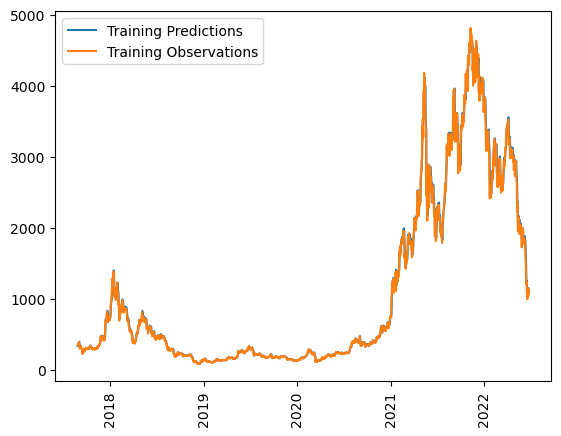

In [16]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [17]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.002264775102958083
Val MAE: 0.0344751738011837


7/7 [==============================] - 1s 3ms/step


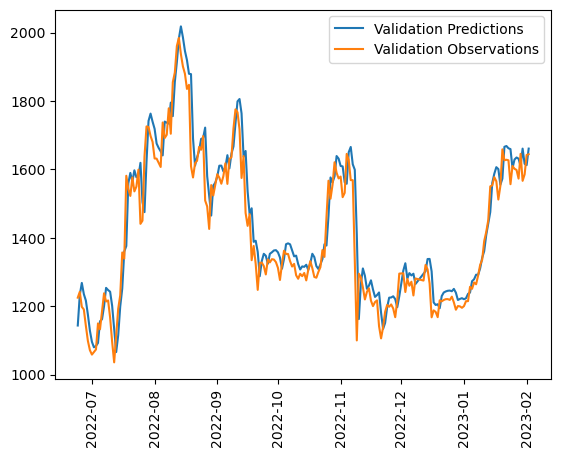

In [18]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [19]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0009451791411265731
Test MAE: 0.025393076241016388


7/7 [==============================] - 0s 5ms/step


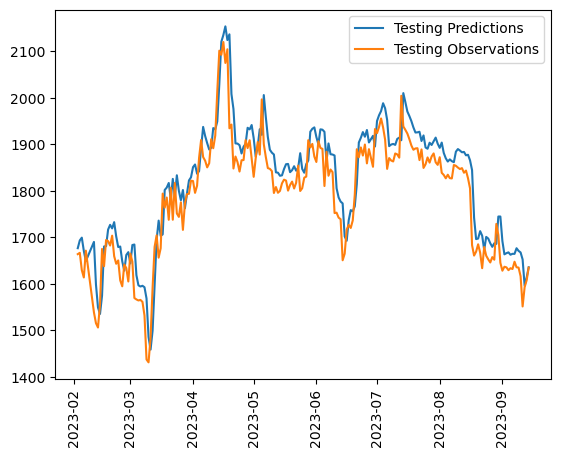

In [20]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [22]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.8215723930806085


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [23]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [24]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((858,), (858, 7), (858,), (132,), (132, 7), (132,), (110,), (110, 7), (110,))

In [25]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
27/27 [==============================] - 4s 32ms/step - loss: 48.8923 - mean_absolute_error: 6.9606 - val_loss: 45.7601 - val_mean_absolute_error: 6.7641
Epoch 2/200
27/27 [==============================] - 0s 9ms/step - loss: 44.4154 - mean_absolute_error: 6.6320 - val_loss: 41.7692 - val_mean_absolute_error: 6.4624
Epoch 3/200
27/27 [==============================] - 0s 9ms/step - loss: 40.0919 - mean_absolute_error: 6.2970 - val_loss: 36.9874 - val_mean_absolute_error: 6.0812
Epoch 4/200
27/27 [==============================] - 0s 10ms/step - loss: 34.5691 - mean_absolute_error: 5.8420 - val_loss: 30.6308 - val_mean_absolute_error: 5.5339
Epoch 5/200
27/27 [==============================] - 0s 8ms/step - loss: 27.7980 - mean_absolute_error: 5.2288 - val_loss: 23.4540 - val_mean_absolute_error: 4.8422
Epoch 6/200
27/27 [==============================] - 0s 8ms/step - loss: 20.4076 - mean_absolute_error: 4.4654 - val_loss: 16.0495 - val_mean_absolute_error: 4.0053
Epoch 7/

Epoch 51/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_absolute_error: 0.0647 - val_loss: 0.0027 - val_mean_absolute_error: 0.0441
Epoch 52/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0065 - mean_absolute_error: 0.0616 - val_loss: 0.0016 - val_mean_absolute_error: 0.0305
Epoch 53/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0611 - val_loss: 0.0019 - val_mean_absolute_error: 0.0349
Epoch 54/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0593 - val_loss: 0.0021 - val_mean_absolute_error: 0.0372
Epoch 55/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0060 - mean_absolute_error: 0.0589 - val_loss: 0.0017 - val_mean_absolute_error: 0.0318
Epoch 56/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.0580 - val_loss: 0.0019 - val_mean_absolute_error: 0.0344
Epoch 57/200
27/

Epoch 101/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_error: 0.0565 - val_loss: 0.0016 - val_mean_absolute_error: 0.0307
Epoch 102/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0571 - val_loss: 0.0024 - val_mean_absolute_error: 0.0378
Epoch 103/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0571 - val_loss: 0.0016 - val_mean_absolute_error: 0.0305
Epoch 104/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0574 - val_loss: 0.0022 - val_mean_absolute_error: 0.0391
Epoch 105/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.0576 - val_loss: 0.0017 - val_mean_absolute_error: 0.0315
Epoch 106/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_absolute_error: 0.0561 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304
Epoch 107/

Epoch 151/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0053 - mean_absolute_error: 0.0547 - val_loss: 0.0016 - val_mean_absolute_error: 0.0295
Epoch 152/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_absolute_error: 0.0553 - val_loss: 0.0020 - val_mean_absolute_error: 0.0333
Epoch 153/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_absolute_error: 0.0562 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313
Epoch 154/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0556 - val_loss: 0.0023 - val_mean_absolute_error: 0.0397
Epoch 155/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_error: 0.0569 - val_loss: 0.0019 - val_mean_absolute_error: 0.0323
Epoch 156/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0559 - val_loss: 0.0015 - val_mean_absolute_error: 0.0295
Epoch 157/

27/27 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0525 - val_loss: 0.0018 - val_mean_absolute_error: 0.0322


27/27 [==============================] - 1s 3ms/step


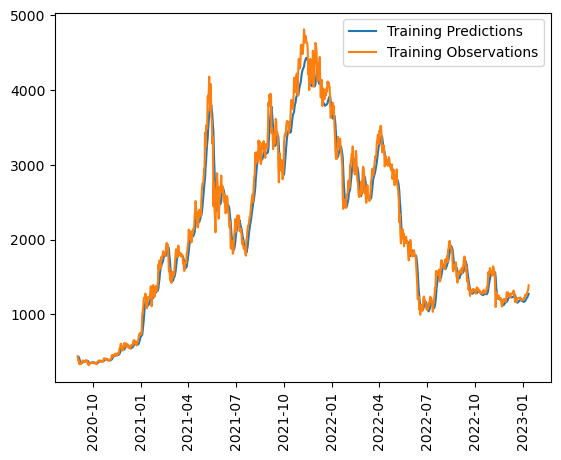

In [26]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0018354356288909912
Val MAE: 0.03216947615146637


5/5 [==============================] - 0s 3ms/step


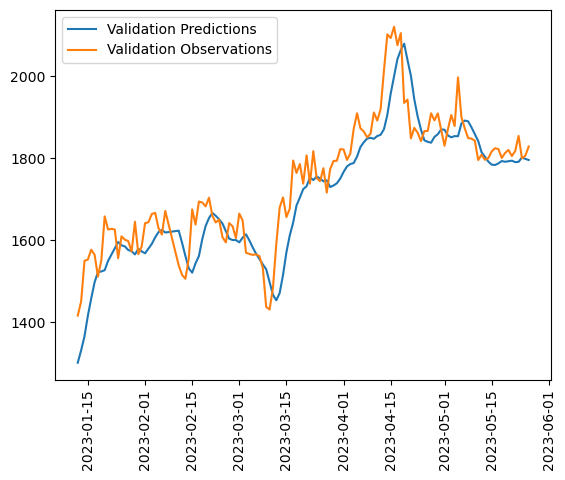

In [28]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0007086637197062373
Test MAE: 0.019442493095993996


In [30]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 3ms/step
R2 Score:  0.8096758720690703


4/4 [==============================] - 0s 3ms/step


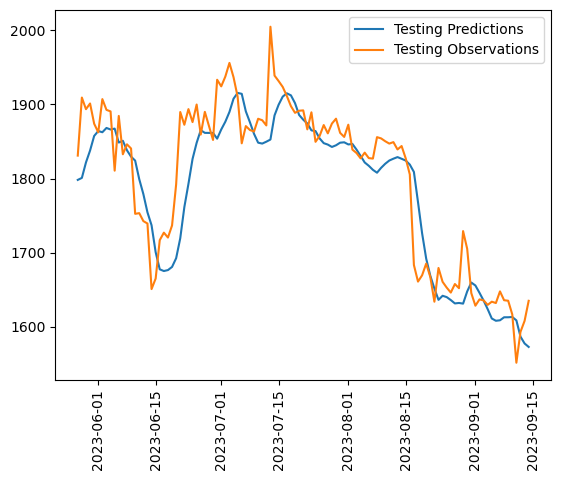

In [31]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [32]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
27/27 [==============================] - 3s 27ms/step - loss: 57.5862 - mean_absolute_error: 7.5570 - val_loss: 54.4014 - val_mean_absolute_error: 7.3752
Epoch 2/300
27/27 [==============================] - 0s 8ms/step - loss: 52.4380 - mean_absolute_error: 7.2090 - val_loss: 49.3023 - val_mean_absolute_error: 7.0210
Epoch 3/300
27/27 [==============================] - 0s 8ms/step - loss: 47.6174 - mean_absolute_error: 6.8677 - val_loss: 44.5758 - val_mean_absolute_error: 6.6760
Epoch 4/300
27/27 [==============================] - 0s 9ms/step - loss: 41.9785 - mean_absolute_error: 6.4438 - val_loss: 37.7086 - val_mean_absolute_error: 6.1402
Epoch 5/300
27/27 [==============================] - 0s 8ms/step - loss: 34.0722 - mean_absolute_error: 5.7971 - val_loss: 28.8153 - val_mean_absolute_error: 5.3674
Epoch 6/300
27/27 [==============================] - 0s 8ms/step - loss: 24.5973 - mean_absolute_error: 4.9121 - val_loss: 18.8222 - val_mean_absolute_error: 4.3377
Epoch 7/3

Epoch 51/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0622 - val_loss: 0.0022 - val_mean_absolute_error: 0.0388
Epoch 52/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0061 - mean_absolute_error: 0.0600 - val_loss: 0.0015 - val_mean_absolute_error: 0.0297
Epoch 53/300
27/27 [==============================] - 0s 12ms/step - loss: 0.0058 - mean_absolute_error: 0.0582 - val_loss: 0.0015 - val_mean_absolute_error: 0.0307
Epoch 54/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0056 - mean_absolute_error: 0.0565 - val_loss: 0.0016 - val_mean_absolute_error: 0.0317
Epoch 55/300
27/27 [==============================] - 0s 14ms/step - loss: 0.0059 - mean_absolute_error: 0.0590 - val_loss: 0.0016 - val_mean_absolute_error: 0.0300
Epoch 56/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0057 - mean_absolute_error: 0.0567 - val_loss: 0.0015 - val_mean_absolute_error: 0.0305
Epoch 57/300

Epoch 101/300
27/27 [==============================] - 0s 10ms/step - loss: 0.0051 - mean_absolute_error: 0.0532 - val_loss: 0.0015 - val_mean_absolute_error: 0.0295
Epoch 102/300
27/27 [==============================] - 0s 11ms/step - loss: 0.0052 - mean_absolute_error: 0.0542 - val_loss: 0.0016 - val_mean_absolute_error: 0.0314
Epoch 103/300
27/27 [==============================] - 0s 10ms/step - loss: 0.0052 - mean_absolute_error: 0.0541 - val_loss: 0.0015 - val_mean_absolute_error: 0.0308
Epoch 104/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0051 - mean_absolute_error: 0.0532 - val_loss: 0.0020 - val_mean_absolute_error: 0.0363
Epoch 105/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_absolute_error: 0.0549 - val_loss: 0.0016 - val_mean_absolute_error: 0.0310
Epoch 106/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_absolute_error: 0.0539 - val_loss: 0.0015 - val_mean_absolute_error: 0.0291
Epoch 1

27/27 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0526 - val_loss: 0.0014 - val_mean_absolute_error: 0.0280
Epoch 151/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0525 - val_loss: 0.0015 - val_mean_absolute_error: 0.0294
Epoch 152/300
27/27 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_absolute_error: 0.0515 - val_loss: 0.0014 - val_mean_absolute_error: 0.0279
Epoch 153/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_absolute_error: 0.0553 - val_loss: 0.0027 - val_mean_absolute_error: 0.0444
Epoch 154/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_absolute_error: 0.0548 - val_loss: 0.0016 - val_mean_absolute_error: 0.0298
Epoch 155/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0527 - val_loss: 0.0014 - val_mean_absolute_error: 0.0282
Epoch 156/300
27/27 [===

Epoch 200/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0529 - val_loss: 0.0013 - val_mean_absolute_error: 0.0271
Epoch 201/300
27/27 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_absolute_error: 0.0502 - val_loss: 0.0013 - val_mean_absolute_error: 0.0270
Epoch 202/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_absolute_error: 0.0500 - val_loss: 0.0015 - val_mean_absolute_error: 0.0306
Epoch 203/300
27/27 [==============================] - 0s 11ms/step - loss: 0.0048 - mean_absolute_error: 0.0517 - val_loss: 0.0020 - val_mean_absolute_error: 0.0351
Epoch 204/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_absolute_error: 0.0514 - val_loss: 0.0013 - val_mean_absolute_error: 0.0273
Epoch 205/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_absolute_error: 0.0500 - val_loss: 0.0013 - val_mean_absolute_error: 0.0280
Epoch 20

27/27 [==============================] - 0s 10ms/step - loss: 0.0044 - mean_absolute_error: 0.0493 - val_loss: 0.0013 - val_mean_absolute_error: 0.0276
Epoch 250/300
27/27 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_absolute_error: 0.0483 - val_loss: 0.0013 - val_mean_absolute_error: 0.0265
Epoch 251/300
27/27 [==============================] - 0s 10ms/step - loss: 0.0044 - mean_absolute_error: 0.0497 - val_loss: 0.0017 - val_mean_absolute_error: 0.0335
Epoch 252/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_absolute_error: 0.0501 - val_loss: 0.0019 - val_mean_absolute_error: 0.0341
Epoch 253/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0504 - val_loss: 0.0017 - val_mean_absolute_error: 0.0343
Epoch 254/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_absolute_error: 0.0487 - val_loss: 0.0012 - val_mean_absolute_error: 0.0266
Epoch 255/300
27/27 [

27/27 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0474 - val_loss: 0.0020 - val_mean_absolute_error: 0.0382
Epoch 299/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0457 - val_loss: 0.0014 - val_mean_absolute_error: 0.0296
Epoch 300/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0495 - val_loss: 0.0011 - val_mean_absolute_error: 0.0245


27/27 [==============================] - 1s 3ms/step


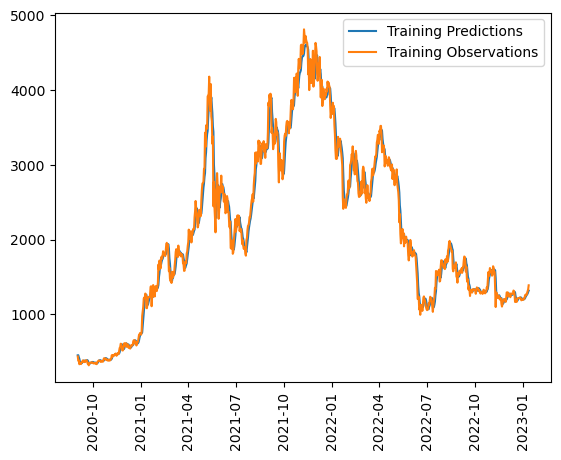

In [33]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [34]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0010846660006791353
Val MAE: 0.024454763159155846


5/5 [==============================] - 0s 4ms/step


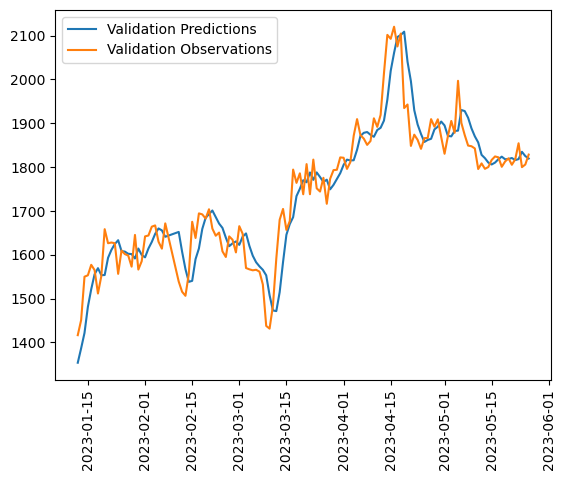

In [35]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [36]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0005204924382269382
Test MAE: 0.0159982331097126


4/4 [==============================] - 0s 3ms/step


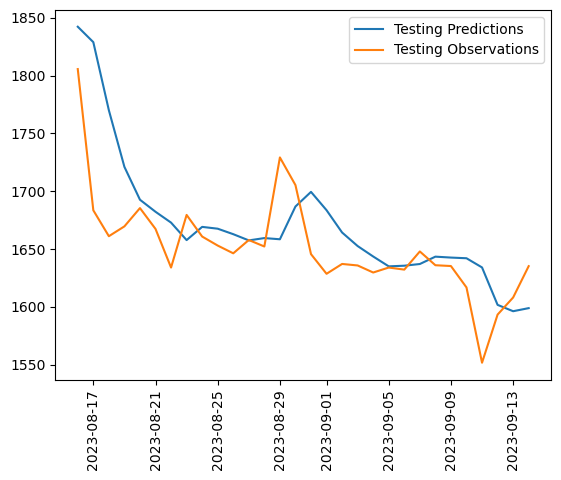

In [37]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [38]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.860212756895467


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [57]:


# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 14

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1].reshape((1, lookback, 1))
initial_date = dates_test2[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# Assuming 'predictions' contains your 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 36ms/step
[7.3770714, 7.377304, 7.3784895, 7.3806987, 7.3830976, 7.383769, 7.3849654, 7.3865757, 7.388053, 7.3894725, 7.3908496, 7.392236, 7.3936663, 7.3950763]
2023-09-15
2023-09-16
2023-09-17
2023-09-18
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-23
2023-09-24
2023-09-25
2023-09-26
2023-09-27
2023-09-28


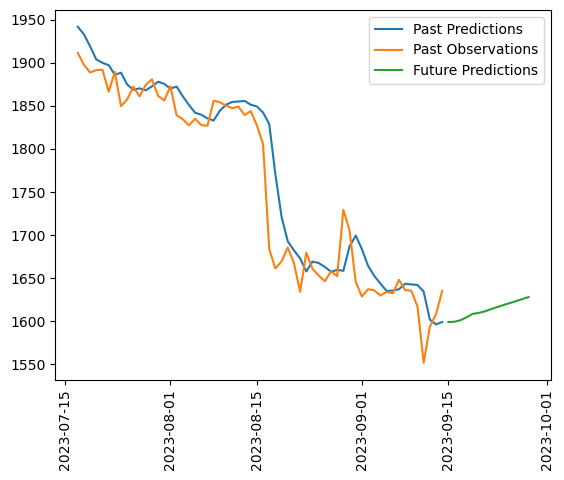

In [58]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [48]:
# Export model to HDF5 file
model3.save("H5_Files/eth_7_day.h5")

In [59]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2, "observed":np.exp(y_test2), "predicted":np.exp(test_predictions3)})
df.set_index('Date', inplace=True)

df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
df2.set_index('Date', inplace=True)                   
                    
past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


past_future_df.head()


,observed,predicted,future_prediction
Date,,,
2023-05-27,1831.0,1824.731689,NaN
2023-05-28,1909.3,1829.234619,NaN
2023-05-29,1893.6,1862.299438,NaN
2023-05-30,1901.3,1880.101562,NaN
2023-05-31,1874.0,1896.961060,NaN


In [60]:
past_future_df.tail()

,observed,predicted,future_prediction
Date,,,
2023-09-24,NaN,NaN,1618.851807
2023-09-25,NaN,NaN,1621.082764
2023-09-26,NaN,NaN,1623.332031
2023-09-27,NaN,NaN,1625.655273
2023-09-28,NaN,NaN,1627.948975


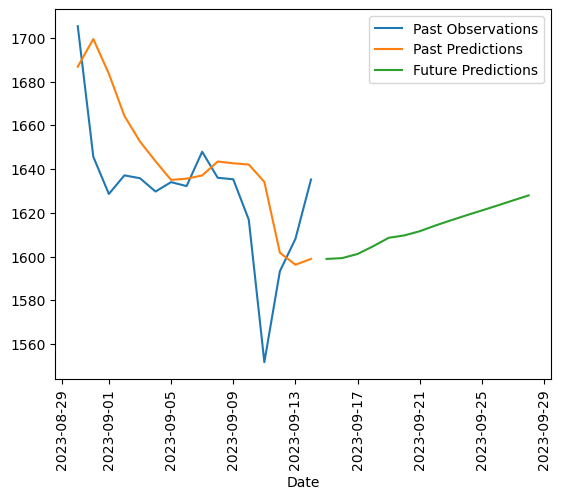

In [61]:
past_future_df[-30:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Past Observations', 'Past Predictions','Future Predictions'])
plt.show()

In [64]:
past_df = pd.read_csv('output/eth_predict.csv')

past_df = past_df[["predicted"]]

past_df = past_df.rename(columns={"predicted":"past_pred"})

df_combined = pd.merge(past_future_df,past_df, how='outer', left_index=True, right_index=True)

df_combined.head()

,observed,predicted,future_prediction,past_pred
2023-05-27,1831.0,1824.731689,NaN,NaN
2023-05-28,1909.3,1829.234619,NaN,NaN
2023-05-29,1893.6,1862.299438,NaN,NaN
2023-05-30,1901.3,1880.101562,NaN,NaN
2023-05-31,1874.0,1896.961060,NaN,NaN


In [67]:
#output prediction data to csv
df.to_csv('output/eth_predict.csv') 

In [66]:
#output historical prediction data to csv
past_future_df.to_csv('output/eth_hist_predict.csv') 

In [47]:
#output original historical data to csv
data.to_csv('output/eth_lifetime.csv')